Imports and inital assignments. These weeks were chosen based on the peaks in Spring exhibited in the chart on slide 3.

In [14]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from __future__ import division
from difflib import SequenceMatcher
import seaborn as sns; sns.set()
%matplotlib inline

base = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
days = ['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
months = {'Spring': ['160528.txt',
 '160521.txt',
 '160514.txt',
 '160507.txt',
 '160430.txt',
 '160423.txt',
 '160416.txt',
 '160409.txt',
 '160402.txt',
 '160326.txt',
 '160319.txt',
 '160312.txt',
 '160305.txt']}

The cell below aggregates the data into one dataframe and performs some cleaning.

In [15]:
# Loop through the week files in month_df and store them in a dataframe.  Rename the last column to 'EXITS' (it
# included a bunch of spaces when imported).

for month in months.keys():
    
    dates=months[month]

    mta = pd.read_csv(base + dates[0])

    for date in dates[1:]:
        t = pd.read_csv(base + date)
        mta = pd.concat([mta,t])

    names = mta.columns.tolist()
    names[-1]='EXITS'
    mta.columns=names

# For each hour block (grouped by unique turnstile and in date order), create counts from cumulative values 
# by subtracting the value for a block from the value for the following block.  This makes the very last hour
# block NaN for each turnstile, so we drop it.

    df=mta.copy()
    df['ID'] = df['C/A']+df.UNIT+df.STATION+df.SCP
    df = df.groupby(['ID','C/A','UNIT','STATION','SCP','DATE','TIME','LINENAME',]).sum()
    first = df[['ENTRIES','EXITS']]
    last = df[['ENTRIES','EXITS']].groupby(level=0).shift(-1)
    df = (last-first).dropna()

# Remove hour block entries and exits for each turnstile that are negative or >5000 (for a turnstile, someone
# entering every 3 seconds through the entire four hour block means 4800 entries. So, it seems reasonable to cap
# at 5000 to allow for some legitimate instances of heavy traffic).  Create datetime variables.

    df = df[(df.EXITS>=0) & (df.ENTRIES>=0) & (df.ENTRIES<=5000) & (df.EXITS<=5000)]
    df = df.reset_index()
    del df['ID']
    df['date'] = pd.to_datetime(df.DATE, format='%m/%d/%Y')
    df['time'] = pd.to_datetime(df.TIME,format='%H:%M:%S')
    df['day'] = df.date.dt.dayofweek
    df['hour'] = df.time.dt.hour
    df['daypart'] = df.hour
    dp = zip((6,7,8,9,10,11,12,13,14,15,16,17),(sum([['Morning']*3, ['Afternoon']*5, ['Evening']*4],[])))
    daypart={}
    for i in dp:
        daypart[i[0]]=i[1]
    df.daypart = df.replace({'daypart':daypart}).daypart
    
# We should group by stations and lines to make sure we don't aggregate geographically different stations with
# the same name. But, LINENAME is not clean - e.g. '34 ST-PENN STA' has the lines 'ACE', '123', and '123ACE'.
# We create a new line variable that checks whether a line is a subset of a different line for the same station,
# and reassigns the linenames to the most inclusive one.  After, '34 ST-PENN STA' should only have '123ACE'.

    lines = [[station, list(df.LINENAME[df.STATION==station].unique())] 
                        for station in df.STATION.unique()]
    for line in lines:
        line[1].sort(key = lambda x: len(x))
    lines_v2=[[line[0],[''.join(sorted(list(item))) 
                        for item in line[1]]] for line in lines]

    lines_v3 = []
    for line in lines_v2:
        to_append=[]
        for i in range(len(line[1])):
            j_range = range(len(line[1]))
            if len(j_range)>1:
                j_range.remove(i)
            counter = 0
            for j in j_range:
                if line[1][i] in line[1][j]:
                    break
                else:
                    counter +=1
            if counter<len(j_range):
                to_append.append(line[1][j])
            else:
                to_append.append(line[1][i])
        lines_v3.append([line[0],to_append])

    new_lines = pd.DataFrame(sum([line[0:1]*len(line[1]) for line in lines],[]),columns=['STATION'])
    new_lines['LINENAME']=sum([line[1] for line in lines],[])
    new_lines['NEW_STATION']=sum([line[0:1]*len(line[1]) for line in lines_v3],[])
    new_lines['line']=sum([line[1] for line in lines_v3],[])
    df = pd.merge(df,new_lines,how='left')
    df['tot'] = df.ENTRIES + df.EXITS

Below is the code for the different plots.  The plot on slide 3 with fluctuations over the last 1.5 years was generated by looping through turnstile file 4 weeks at a time, summing up total ridership for each loop, and plotting each point (with the x coordinate being the first week of the 4).

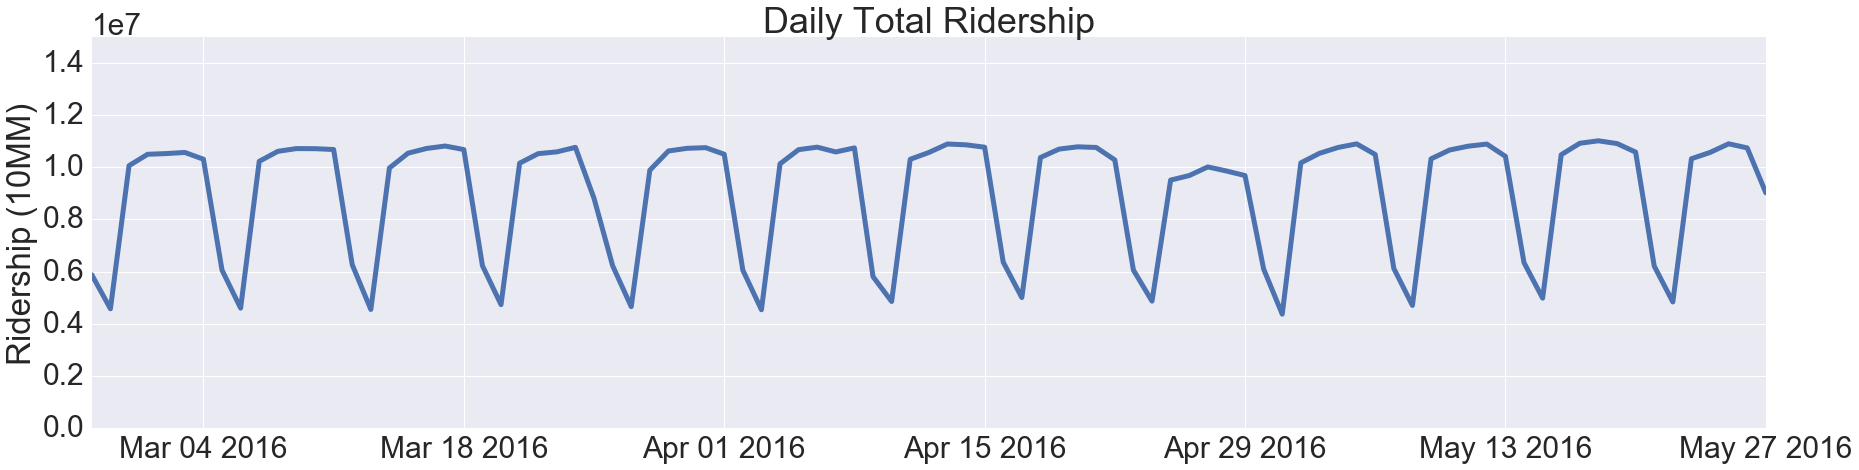

In [16]:
# Plot fluctuations in daily ridership over Spring period

t = df.groupby(['date'], as_index = False).sum()
sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 5})
plt.figure(figsize = (30,7))
plt.plot(t.date, t.tot)
ax = plt.gca()
ax.set_ylim([0,15000000]);
plt.title('Daily Total Ridership')
plt.ylabel('Ridership (10MM)');

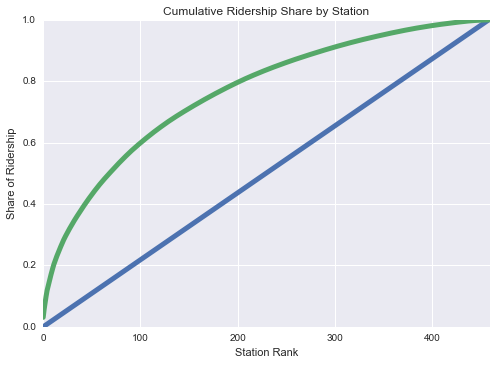

In [17]:
# Plot cumulative share of ridership for stations, sorted by total ridership

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 5})
t = df.groupby(['STATION','line']).sum()
t = t.sort_values('tot',ascending=False)
t['cs'] = t.tot.cumsum()/t.tot.sum()
ax = plt.subplot()
ax.plot(range(0,t.ENTRIES.count()),np.linspace(0,1,t.ENTRIES.count()))
ax.plot(range(0,t.ENTRIES.count()), t.cs)
ax.set_xlim([0,t.ENTRIES.count()])
ax.set_xlabel('Station Rank')
ax.set_ylabel('Share of Ridership')
ax.set_title('Cumulative Ridership Share by Station');

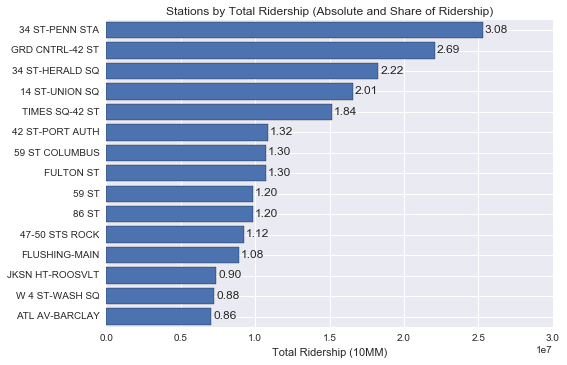

In [18]:
# Plot top 15 stations by ridership, showing absolute and share of total ridership

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 5})
t = df.groupby(['STATION','line'], as_index = False).sum()
t['share'] = (t.tot/t.tot.sum())
t = t.sort_values('tot',ascending = False)[:15][::-1][['STATION','line','tot','share']]
plt.barh(range(15), t['tot'],align = 'center')
plt.yticks(range(15),t['STATION']);
plt.xlabel('Total Ridership (10MM)')
ax = plt.gca()
ax.set_ylim([-0.5,14.5])
plt.title('Stations by Total Ridership (Absolute and Share of Ridership)')
labels = list(t.share*100)
i=0
top_5 = list(t.STATION)[::-1][:5]
for p in ax.patches:
    ax.annotate("%.2f" % labels[i],(p.get_x() + p.get_width(), p.get_y()), xytext=(2,6), textcoords='offset points');
    i+=1

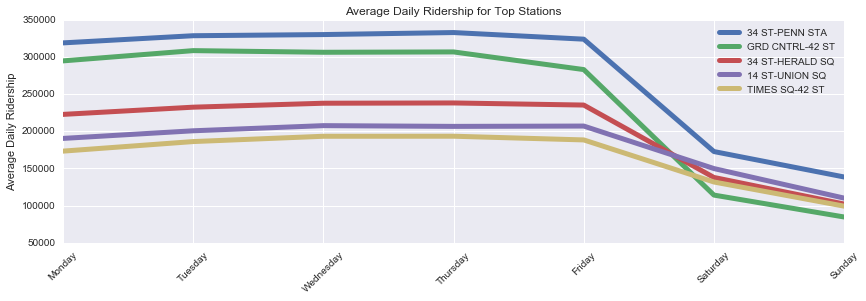

In [19]:
# Plot average daily ridership by station to compare station activity by day of week

sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 5})
daily = df.groupby(['STATION','line','day']).sum().reset_index()
daily[daily.STATION.isin(top_5)]

plt.figure(figsize=[14,4])
for stat in top_5:
    plt.plot(daily.day[daily.STATION==stat],daily.tot[daily.STATION==stat]/13, label = stat)
plt.xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation=45)
plt.legend(top_5)
plt.ylabel('Average Daily Ridership')
plt.title('Average Daily Ridership for Top Stations');

In [7]:
top_5

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST']

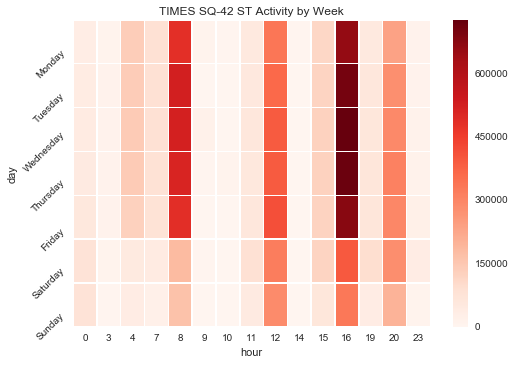

In [20]:
# Create heatmaps of popular day of week/time of day intersections for top stations by specifying 'stat'

stat = 'TIMES SQ-42 ST'
t = df.groupby(['STATION','line','hour','day']).sum().sort_values('tot',ascending=False).reset_index()
t = t[t.STATION==stat].sort_values(['day','hour'])
t = t.pivot('day','hour','tot')
ax = sns.heatmap(t.fillna(0),cmap='Reds', linewidths=.5)
plt.yticks(range(7),days,rotation=45);
plt.title(stat + ' Activity by Week');

The code below uses a manually compiled set of coordinate to map big stations and total traffic, highlighting flow by time of day throughout NYC.

In [11]:
# Create a map of large NYC stations by importing t into Tableau

coord = {
        '34 ST-PENN STA':(40.750568,-73.9957077),
        'GRD CNTRL-42 ST':(40.7527262,-73.9794181),
        '34 ST-HERALD SQ':(40.7496439,-73.9898593),
        '14 ST-UNION SQ':(40.7352761,-73.9932399),
        'TIMES SQ-42 ST':(40.7556212,-73.9885374),
        '42 ST-PORT AUTH':(40.756567,-73.9931107),
        '59 ST COLUMBUS':(40.7687348,-73.9842965),
        'FULTON ST':(40.7104122,-74.0119366),
        '59 ST':(40.7615569,-73.9671796),
        '86 ST':(40.7852756,-73.9717919),
        'FLUSHING-MAIN':(40.759699,-73.8321667),
        '47-50 STS ROCK':(40.7593474,-73.9850058),
        'JKSN HT-ROOSVLT':(40.7467195,-73.8932539),
        'W 4 ST-WASH SQ':(40.732117,-74.0034669),
        'ATL AV-BARCLAY':(40.684901,-73.9798687),
        'CANAL ST':(40.7195147,-74.0039744),
        '96 ST':(40.7858636,-73.9531386),
        'LEXINGTON AV/53':(40.757552,-73.9712437),
        '14 ST':(40.7380575,-73.99816050),
        '42 ST-BRYANT PK':(40.7544631,-73.9845289),
        'CHAMBERS ST':(40.7130583,-74.0099695)
        }

coord_lat = dict([[key,value[0]] for key,value in coord.iteritems()])
coord_long = dict([[key,value[1]] for key,value in coord.iteritems()])

t = df.groupby(['STATION','line','hour'], as_index = False).sum()
t['share'] = (t.tot/t.tot.sum())
t = t.sort_values('tot',ascending = False)
t = t[t.STATION.isin(coord.keys())]
t['lat']=t.STATION.map(coord_lat)
t['long']=t.STATION.map(coord_long)
t['dp'] = t.hour.map(daypart)

/Users/RJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


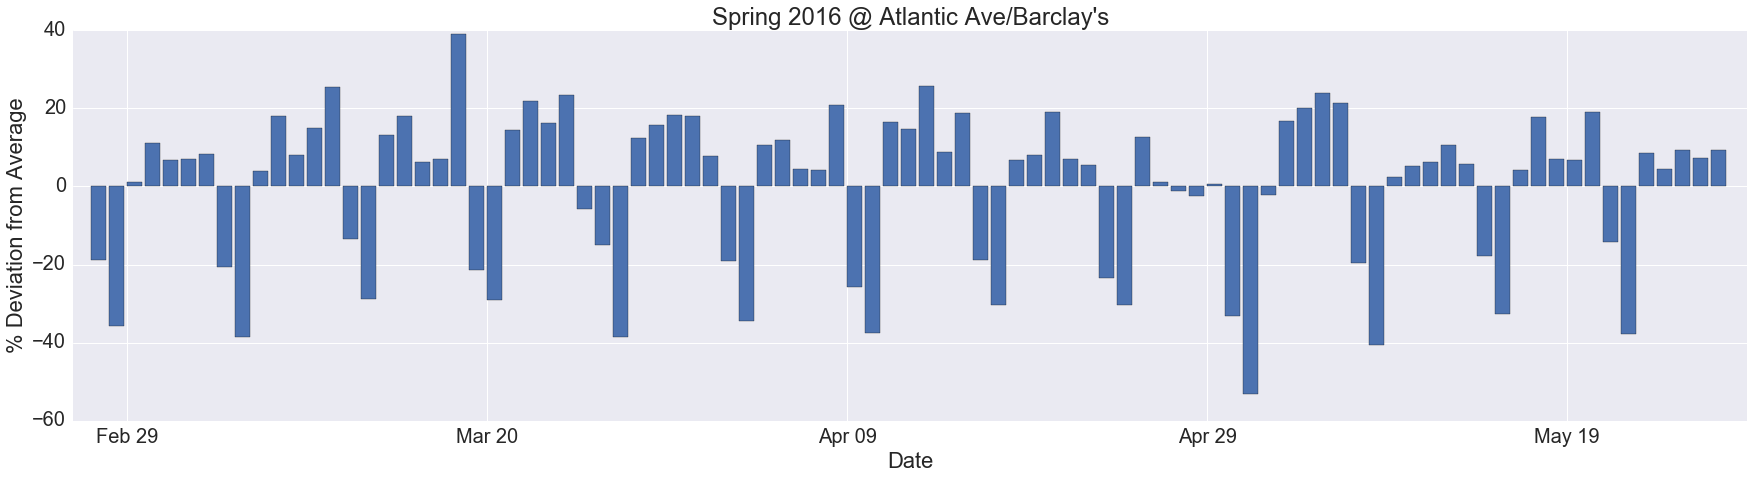

In [21]:
# Create plot of daily Barclay's center traffic in relation to average (% deviation)

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 5})

t = df.groupby(['STATION','line','date'], as_index = False).sum()[['STATION','line','date','ENTRIES','EXITS']]
t['tot'] = t['ENTRIES']+t['EXITS']
t['day'] = t['date'].dt.dayofyear

t[t['STATION']=='ATL AV-BARCLAY'].groupby('date', as_index = False).sum().sort_values('tot', ascending = False)
bdf = t[t['STATION']=='ATL AV-BARCLAY']
m = bdf.tot.mean()
bdf['delta'] = (bdf['tot'] - m)*100/m
plt.figure(figsize = (30,7))
plt.bar(bdf['day'],bdf['delta'])
ax = plt.gca()
ax.set_xlim([57,150])

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Feb 29'
labels[2] = 'Mar 20'
labels[3] = 'Apr 09'
labels[4] = 'Apr 29'
labels[5] = 'May 19'
ax.set_xticklabels(labels)
plt.title("Spring 2016 @ Atlantic Ave/Barclay's")
plt.xlabel('Date')
plt.ylabel('% Deviation from Average');